# 1. Instalación de dependencias

In [ ]:
# Instalar keras-facenet para usar FaceNet preentrenado
# !pip install keras-facenet tensorflow pillow scikit-learn matplotlib seaborn

# 2. Importaciones necesarias

In [3]:
import os
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# FaceNet
from keras_facenet import FaceNet

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


# 3. Configuración y rutas

In [4]:
# Configuración
DATASET_PATH = Path('../PreprocesamientoImagenes/TrainingData/faces')
MODEL_SAVE_PATH = Path('models')
MODEL_SAVE_PATH.mkdir(exist_ok=True)

# Parámetros
IMG_SIZE = 160  # Tamaño requerido por FaceNet
EMBEDDING_SIZE = 512  # Dimensión de embeddings de FaceNet (keras-facenet usa 512D)
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_STATE = 42

print(f"Dataset path: {DATASET_PATH}")
print(f"Verificando dataset...")
if DATASET_PATH.exists():
    num_persons = len([d for d in DATASET_PATH.iterdir() if d.is_dir()])
    print(f"✓ Dataset encontrado: {num_persons} personas")
else:
    print(f"✗ Dataset NO encontrado en {DATASET_PATH}")

Dataset path: ..\PreprocesamientoImagenes\TrainingData\faces
Verificando dataset...
✓ Dataset encontrado: 4 personas


# 4. Cargar FaceNet preentrenado

FaceNet es una red neuronal entrenada en millones de rostros que convierte imágenes faciales en vectores de 128 dimensiones (embeddings). Estos embeddings capturan características discriminativas del rostro.

In [5]:
# Cargar FaceNet preentrenado
print("Cargando FaceNet preentrenado...")
facenet_model = FaceNet()
print(f"✓ FaceNet cargado exitosamente")
print(f"  - Input shape: (160, 160, 3)")
print(f"  - Output shape: (512,) embedding vector")
print(f"  - Modelo preentrenado en millones de rostros")

Cargando FaceNet preentrenado...

✓ FaceNet cargado exitosamente
  - Input shape: (160, 160, 3)
  - Output shape: (512,) embedding vector
  - Modelo preentrenado en millones de rostros


# 5. Cargar y preparar dataset

In [6]:
def load_dataset(dataset_path):
    """
    Carga todas las imágenes del dataset organizadas por persona
    
    Returns:
        images: Lista de imágenes (160x160x3)
        labels: Lista de nombres de personas
        label_names: Lista única de nombres
    """
    images = []
    labels = []
    
    print("="*70)
    print("CARGANDO DATASET")
    print("="*70 + "\n")
    
    person_folders = sorted([d for d in dataset_path.iterdir() if d.is_dir()])
    
    for person_folder in person_folders:
        person_name = person_folder.name
        image_files = list(person_folder.glob('*.png'))
        
        print(f"Cargando {person_name}: {len(image_files)} imágenes", end=" ")
        
        loaded = 0
        for img_file in image_files:
            try:
                # Cargar imagen (ya está en RGB 160x160)
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                
                # Convertir BGR a RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Verificar dimensiones
                if img_rgb.shape != (160, 160, 3):
                    img_rgb = cv2.resize(img_rgb, (160, 160))
                
                images.append(img_rgb)
                labels.append(person_name)
                loaded += 1
                
            except Exception as e:
                continue
        
        print(f"→ {loaded} cargadas")
    
    print(f"\n{'='*70}")
    print(f"RESUMEN DE CARGA:")
    print(f"  Total de imágenes: {len(images)}")
    print(f"  Total de personas: {len(set(labels))}")
    print(f"  Shape de imágenes: {images[0].shape if images else 'N/A'}")
    print(f"{'='*70}\n")
    
    return np.array(images), labels

# Cargar dataset
X_images, y_labels = load_dataset(DATASET_PATH)

print(f"Dataset cargado:")
print(f"  X_images shape: {X_images.shape}")
print(f"  Número de labels: {len(y_labels)}")
print(f"  Clases únicas: {len(set(y_labels))}")

CARGANDO DATASET

Cargando AlisonSalas: 413 imágenes → 413 cargadas
Cargando FreddyAlvarez: 413 imágenes → 413 cargadas
Cargando IsmaelSailema: 413 imágenes → 413 cargadas
Cargando WilliamChimborazo: 413 imágenes → 413 cargadas

RESUMEN DE CARGA:
  Total de imágenes: 1652
  Total de personas: 4
  Shape de imágenes: (160, 160, 3)

Dataset cargado:
  X_images shape: (1652, 160, 160, 3)
  Número de labels: 1652
  Clases únicas: 4


# 6. Codificar labels (nombres → números)

In [7]:
# Codificar nombres a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

num_classes = len(label_encoder.classes_)

print(f"Codificación de labels:")
print(f"  Número de clases: {num_classes}")
print(f"  Nombres de clases: {list(label_encoder.classes_)}")
print(f"\nEjemplos de mapeo:")
for i, name in enumerate(label_encoder.classes_[:5]):
    print(f"  {name} → {i}")

# Guardar label encoder para uso posterior
with open(MODEL_SAVE_PATH / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"\n✓ Label encoder guardado en {MODEL_SAVE_PATH / 'label_encoder.pkl'}")

Codificación de labels:
  Número de clases: 4
  Nombres de clases: [np.str_('AlisonSalas'), np.str_('FreddyAlvarez'), np.str_('IsmaelSailema'), np.str_('WilliamChimborazo')]

Ejemplos de mapeo:
  AlisonSalas → 0
  FreddyAlvarez → 1
  IsmaelSailema → 2
  WilliamChimborazo → 3

✓ Label encoder guardado en models\label_encoder.pkl


# 7. Extraer embeddings con FaceNet

Este es el paso clave: convertimos cada imagen (160x160x3) en un vector de 512 dimensiones usando FaceNet preentrenado.

In [8]:
def extract_embeddings(images, facenet_model, batch_size=32):
    """
    Extrae embeddings de FaceNet para todas las imágenes
    
    Args:
        images: Array de imágenes (N, 160, 160, 3)
        facenet_model: Modelo FaceNet cargado
        batch_size: Tamaño del batch para procesamiento
    
    Returns:
        embeddings: Array de embeddings (N, 512)
    """
    print("="*70)
    print("EXTRAYENDO EMBEDDINGS CON FACENET")
    print("="*70 + "\n")
    
    num_images = len(images)
    embeddings = []
    
    # Procesar en batches para eficiencia
    for i in range(0, num_images, batch_size):
        batch = images[i:i+batch_size]
        
        # FaceNet espera valores en [0, 255]
        batch_embeddings = facenet_model.embeddings(batch)
        embeddings.append(batch_embeddings)
        
        # Progreso
        processed = min(i + batch_size, num_images)
        print(f"Procesadas: {processed}/{num_images} imágenes ({processed/num_images*100:.1f}%)", end="\r")
    
    embeddings = np.vstack(embeddings)
    
    print(f"\n\n{'='*70}")
    print(f"EMBEDDINGS EXTRAÍDOS:")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Rango de valores: [{embeddings.min():.3f}, {embeddings.max():.3f}]")
    print(f"  Media: {embeddings.mean():.3f}")
    print(f"  Desviación estándar: {embeddings.std():.3f}")
    print(f"{'='*70}\n")
    
    return embeddings

# Extraer embeddings
X_embeddings = extract_embeddings(X_images, facenet_model, batch_size=BATCH_SIZE)

# Liberar memoria de imágenes originales (ya no las necesitamos)
del X_images
print("✓ Memoria de imágenes originales liberada")

EXTRAYENDO EMBEDDINGS CON FACENET

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287m

# 8. Dividir en train/validation/test

In [9]:
# Dividir dataset: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_embeddings, y_categorical, 
    test_size=0.15, 
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 del total
    random_state=RANDOM_STATE,
    stratify=y_encoded[:-len(y_test)]
)

print("="*70)
print("DIVISIÓN DEL DATASET")
print("="*70)
print(f"Train:      {X_train.shape[0]} muestras ({X_train.shape[0]/len(X_embeddings)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X_embeddings)*100:.1f}%)")
print(f"Test:       {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_embeddings)*100:.1f}%)")
print(f"{'='*70}\n")

# Verificar distribución de clases
print("Distribución de clases en Train:")
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {label_encoder.classes_[cls]}: {count} muestras")

DIVISIÓN DEL DATASET
Train:      1156 muestras (70.0%)
Validation: 248 muestras (15.0%)
Test:       248 muestras (15.0%)

Distribución de clases en Train:
  Clase AlisonSalas: 285 muestras
  Clase FreddyAlvarez: 289 muestras
  Clase IsmaelSailema: 294 muestras
  Clase WilliamChimborazo: 288 muestras


# 9. Construir CNN Clasificadora

Esta es **tu propia CNN** que aprenderá a clasificar los embeddings de FaceNet. Es una red simple pero efectiva que trabaja sobre vectores de 512 dimensiones.

In [10]:
def create_classifier_cnn(input_dim=512, num_classes=10):
    """
    Crea una CNN clasificadora que trabaja sobre embeddings de FaceNet
    
    Arquitectura:
        Input (512) → Dense(256) → Dropout → Dense(128) → Dropout → Dense(num_classes)
    
    Args:
        input_dim: Dimensión del embedding (512 para FaceNet)
        num_classes: Número de personas a clasificar
    
    Returns:
        model: Modelo de Keras compilado
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer 1
        layers.Dense(256, activation='relu', name='dense_1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Hidden layer 2
        layers.Dense(128, activation='relu', name='dense_2'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Hidden layer 3
        layers.Dense(64, activation='relu', name='dense_3'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Crear modelo
model = create_classifier_cnn(input_dim=EMBEDDING_SIZE, num_classes=num_classes)

print("="*70)
print("ARQUITECTURA DEL MODELO CNN CLASIFICADOR")
print("="*70 + "\n")
model.summary()
print(f"\n{'='*70}")
print(f"Total de parámetros entrenables: {model.count_params():,}")
print(f"{'='*70}\n")

ARQUITECTURA DEL MODELO CNN CLASIFICADOR



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,532 (681.77 KB)

 Trainable params: 173,636 (678.27 KB)

 Non-trainable params: 896 (3.50 KB)


Total de parámetros entrenables: 174,532



# 10. Callbacks para entrenamiento

In [11]:
# Configurar callbacks
callbacks = [
    # Early stopping: detener si no mejora la validación
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Guardar mejor modelo
    ModelCheckpoint(
        filepath=str(MODEL_SAVE_PATH / 'best_classifier_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reducir learning rate si no mejora
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurados:")
print("  ✓ EarlyStopping (patience=10)")
print("  ✓ ModelCheckpoint (mejor modelo)")
print("  ✓ ReduceLROnPlateau (ajuste de learning rate)")

Callbacks configurados:
  ✓ EarlyStopping (patience=10)
  ✓ ModelCheckpoint (mejor modelo)
  ✓ ReduceLROnPlateau (ajuste de learning rate)


# 11. Entrenar modelo

Aquí entrenamos **tu propia CNN** sobre los embeddings extraídos por FaceNet.

In [12]:
print("="*70)
print("INICIANDO ENTRENAMIENTO")
print("="*70 + "\n")

# Entrenar modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print(f"\n{'='*70}")
print("ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}\n")

INICIANDO ENTRENAMIENTO

Epoch 1/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.7824
Epoch 1: val_accuracy improved from None to 0.96774, saving model to models\best_classifier_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8676 - loss: 0.3950 - val_accuracy: 0.9677 - val_loss: 1.0719 - learning_rate: 0.0010
Epoch 2/50
20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.1076 
Epoch 2: val_accuracy did not improve from 0.96774
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9766 - loss: 0.0968 - val_accuracy: 0.7339 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 3/50
22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 0.0858 
Epoch 3: val_accuracy did not improve from 0.96774
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9792 - loss: 0.0738 - val_accuracy: 0.8952 - val_loss: 0.8469 - learning_rate: 0.0010
Epoch 4/50
20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9692 - loss: 0.1108 
Epoch 4: val_accuracy did not improve from 0.96774
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9766 - loss: 0.0822 - val_accuracy: 0.8669 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 5/50
34/37 ━━━━━━━━━━━━━━━━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9870 - loss: 0.0442 - val_accuracy: 0.9758 - val_loss: 0.3589 - learning_rate: 0.0010
Epoch 8/50
20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0322 
Epoch 8: val_accuracy improved from 0.97581 to 0.98387, saving model to models\best_classifier_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9853 - loss: 0.0401 - val_accuracy: 0.9839 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 9/50
20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.0630 
Epoch 9: val_accuracy improved from 0.98387 to 0.99194, saving model to models\best_classifier_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9879 - loss: 0.0506 - val_accuracy: 0.9919 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 10/50
21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0381 
Epoch 10: val_accuracy did not improve from 0.99194
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9888 - loss: 0.0370 - val_accuracy: 0.9919 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 11/50
22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0314 
Epoch 11: val_accuracy did not improve from 0.99194
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9888 - loss: 0.0354 - val_accuracy: 0.9919 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 12/50
21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0154 
Epoch 12: val_accuracy did not improve from 0.99194
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0271 - val_accuracy: 0.9919 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 13/50
22/37 ━━━━━━━━━━━━

# 12. Visualizar curvas de entrenamiento

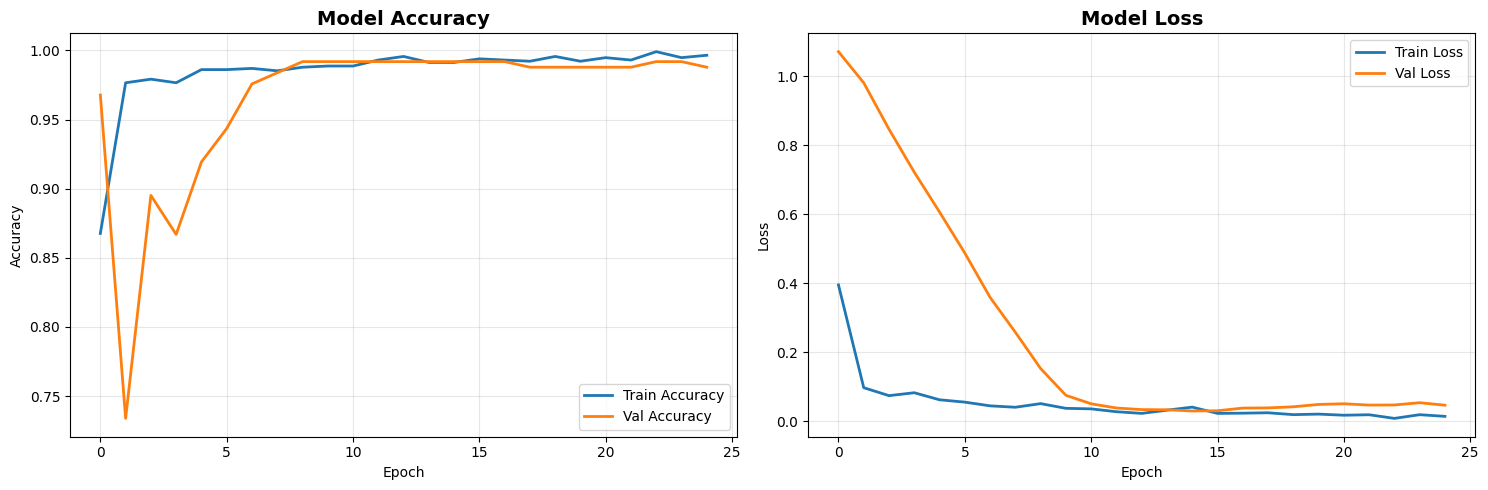

✓ Gráfica guardada en models\training_history.png


In [13]:
# Graficar historial de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_SAVE_PATH / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfica guardada en {MODEL_SAVE_PATH / 'training_history.png'}")

# 13. Evaluar en conjunto de test

In [14]:
print("="*70)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*70 + "\n")

# Evaluar modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predicciones
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Reporte de clasificación
print(f"\n{'='*70}")
print("REPORTE DE CLASIFICACIÓN")
print(f"{'='*70}\n")
print(classification_report(
    y_test_classes, 
    y_pred_classes,
    target_names=label_encoder.classes_,
    digits=4
))

EVALUACIÓN EN CONJUNTO DE TEST

Test Loss: 0.0499
Test Accuracy: 0.9879 (98.79%)

REPORTE DE CLASIFICACIÓN

                   precision    recall  f1-score   support

      AlisonSalas     1.0000    0.9677    0.9836        62
    FreddyAlvarez     1.0000    1.0000    1.0000        62
    IsmaelSailema     0.9538    1.0000    0.9764        62
WilliamChimborazo     1.0000    0.9839    0.9919        62

         accuracy                         0.9879       248
        macro avg     0.9885    0.9879    0.9880       248
     weighted avg     0.9885    0.9879    0.9880       248



# 14. Matriz de confusión

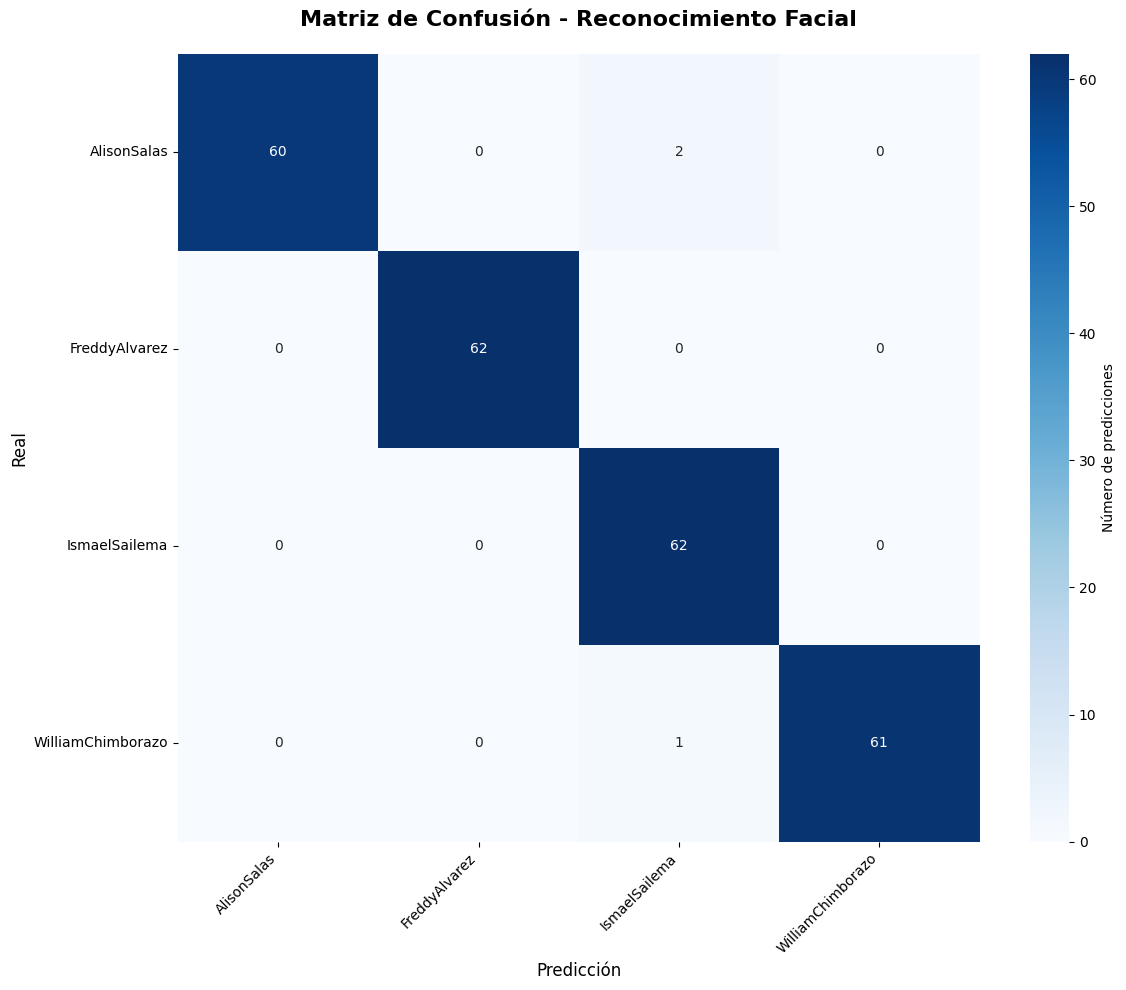

✓ Matriz de confusión guardada en models\confusion_matrix.png


In [15]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Número de predicciones'}
)
plt.title('Matriz de Confusión - Reconocimiento Facial', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(MODEL_SAVE_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Matriz de confusión guardada en {MODEL_SAVE_PATH / 'confusion_matrix.png'}")

# 15. Guardar modelo final

In [16]:
# Guardar modelo completo
model.save(MODEL_SAVE_PATH / 'face_classifier_final.h5')
print(f"✓ Modelo final guardado en {MODEL_SAVE_PATH / 'face_classifier_final.h5'}")

# Guardar embeddings para análisis posterior (opcional)
np.save(MODEL_SAVE_PATH / 'embeddings_train.npy', X_train)
np.save(MODEL_SAVE_PATH / 'embeddings_test.npy', X_test)
print(f"✓ Embeddings guardados")

print("\n" + "="*70)
print("RESUMEN DE ARCHIVOS GUARDADOS")
print("="*70)
print(f"  1. best_classifier_model.h5 - Mejor modelo durante entrenamiento")
print(f"  2. face_classifier_final.h5 - Modelo final después de todas las épocas")
print(f"  3. label_encoder.pkl - Codificador de nombres de personas")
print(f"  4. training_history.png - Gráficas de entrenamiento")
print(f"  5. confusion_matrix.png - Matriz de confusión")
print(f"  6. embeddings_*.npy - Embeddings para análisis")
print("="*70 + "\n")

✓ Modelo final guardado en models\face_classifier_final.h5
✓ Embeddings guardados

RESUMEN DE ARCHIVOS GUARDADOS
  1. best_classifier_model.h5 - Mejor modelo durante entrenamiento
  2. face_classifier_final.h5 - Modelo final después de todas las épocas
  3. label_encoder.pkl - Codificador de nombres de personas
  4. training_history.png - Gráficas de entrenamiento
  5. confusion_matrix.png - Matriz de confusión
  6. embeddings_*.npy - Embeddings para análisis



# 16. Función de predicción para nuevas imágenes

Esta función te permite hacer predicciones sobre nuevas imágenes de rostros.

In [18]:
def predict_face(image_path, facenet_model, classifier_model, label_encoder, threshold=0.5):
    """
    Predice la identidad de un rostro en una imagen
    
    Args:
        image_path: Ruta a la imagen
        facenet_model: Modelo FaceNet para embeddings
        classifier_model: CNN clasificadora entrenada
        label_encoder: Codificador de labels
        threshold: Umbral de confianza mínimo (0-1)
    
    Returns:
        predicted_name: Nombre predicho
        confidence: Confianza de la predicción
    """
    # Cargar imagen
    img = cv2.imread(str(image_path))
    if img is None:
        return None, 0.0
    
    # Convertir a RGB y redimensionar
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (160, 160))
    
    # Extraer embedding
    img_batch = np.expand_dims(img_resized, axis=0)
    embedding = facenet_model.embeddings(img_batch)
    
    # Predecir con clasificador
    prediction = classifier_model.predict(embedding, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Aplicar umbral
    if confidence < threshold:
        return "Desconocido", confidence
    
    predicted_name = label_encoder.classes_[predicted_class]
    
    return predicted_name, confidence

# Ejemplo de uso (descomenta para probar)
# test_image = DATASET_PATH / "persona1" / "persona1_face_0.png"
# if test_image.exists():
#     name, conf = predict_face(test_image, facenet_model, model, label_encoder)
#     print(f"Predicción: {name} (confianza: {conf:.2%})")

# 17. Pruebas con ejemplos del dataset de test

EJEMPLOS DE PREDICCIONES EN TEST SET CON VISUALIZACIÓN

✓ Real: AlisonSalas     | Predicho: AlisonSalas     | Confianza: 99.67%
✓ Real: AlisonSalas     | Predicho: AlisonSalas     | Confianza: 99.75%
✓ Real: IsmaelSailema   | Predicho: IsmaelSailema   | Confianza: 98.87%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.60%
✓ Real: AlisonSalas     | Predicho: AlisonSalas     | Confianza: 99.74%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.49%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.39%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.60%
✓ Real: AlisonSalas     | Predicho: AlisonSalas     | Confianza: 99.74%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.49%
✓ Real: FreddyAlvarez   | Predicho: FreddyAlvarez   | Confianza: 99.39%
✓ Real: IsmaelSailema   | Predicho: IsmaelSailema   | Confianza: 98.85%
✓ Real: IsmaelSailema   | Predicho: IsmaelSailema   | Confianza: 99.16%

Accurac

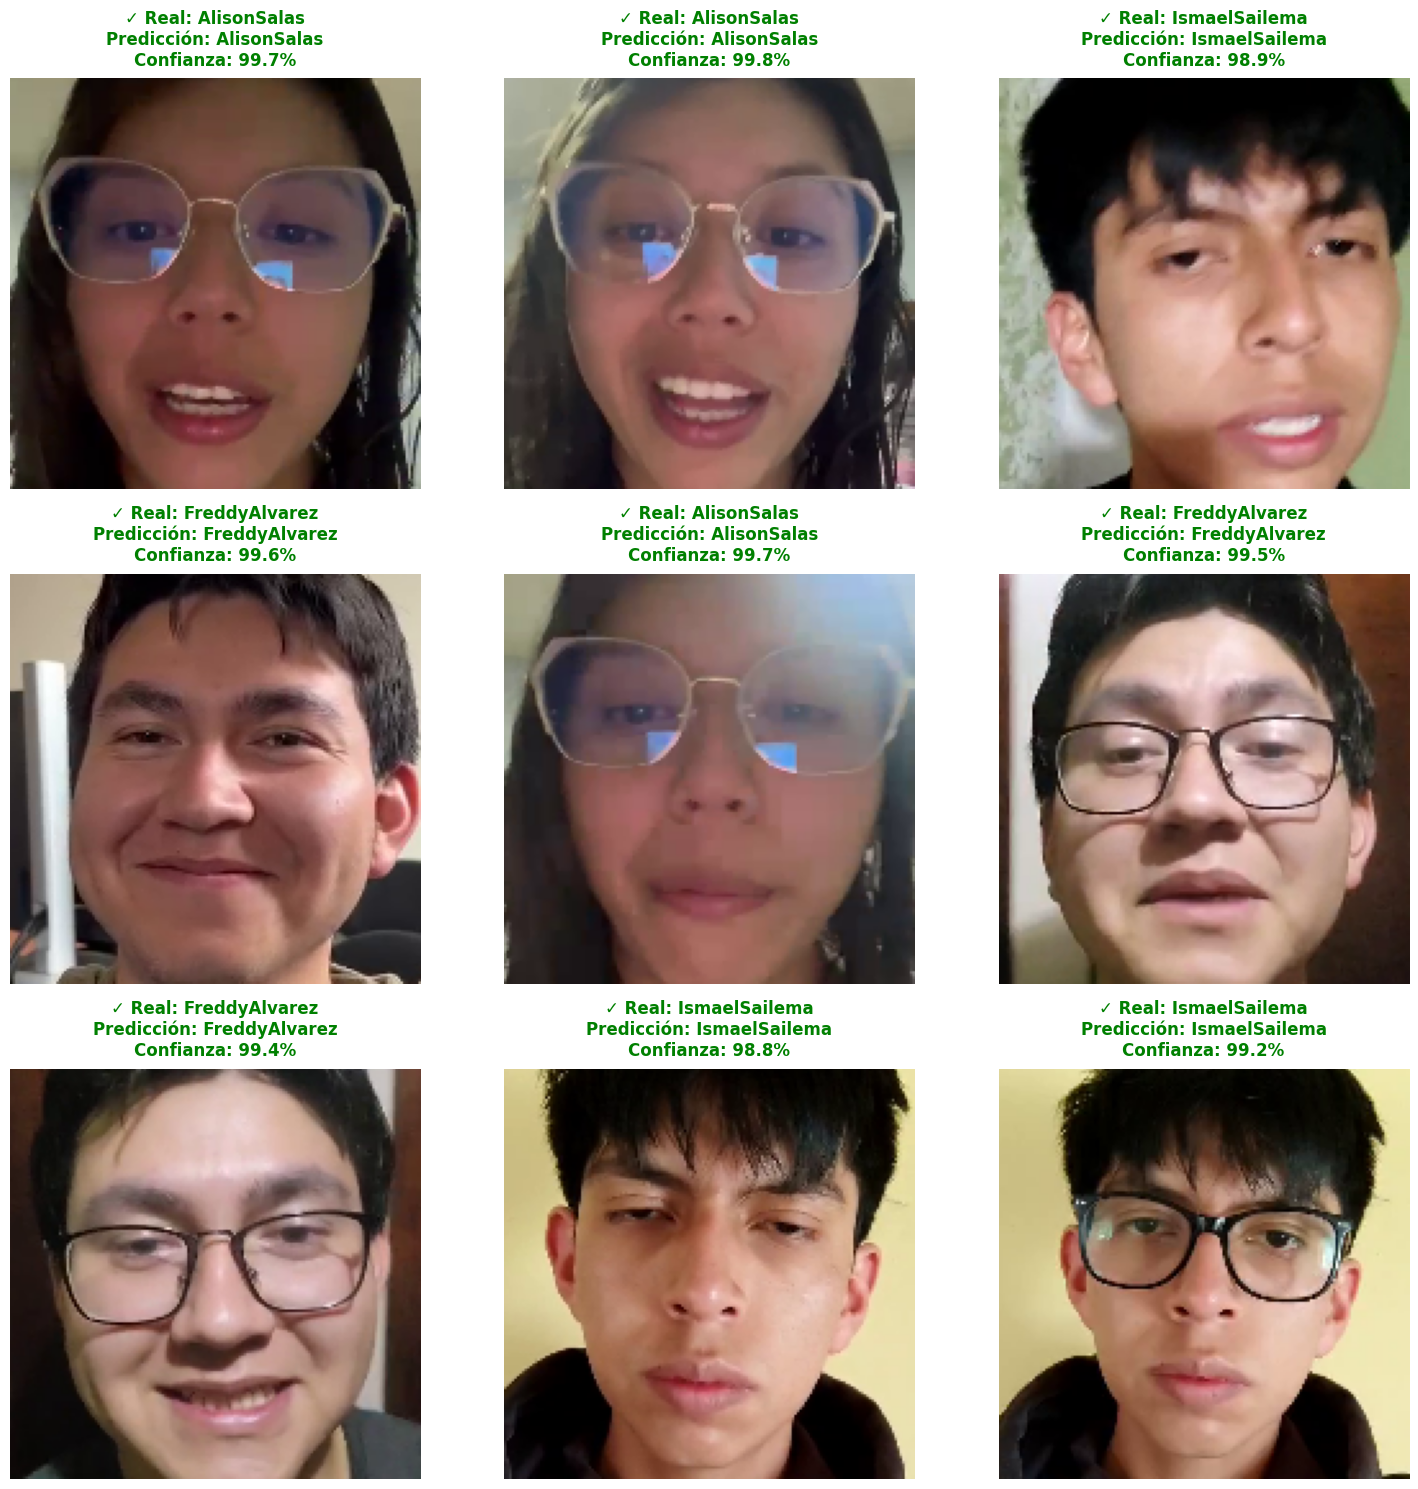

✓ Visualización guardada en models\test_set_predictions.png


In [34]:
# Hacer predicciones de ejemplo en imágenes de test con visualización
num_examples = min(9, len(X_test))  # 9 para cuadrícula 3x3
indices = np.random.choice(len(X_test), num_examples, replace=False)

print("="*70)
print("EJEMPLOS DE PREDICCIONES EN TEST SET CON VISUALIZACIÓN")
print("="*70 + "\n")

# Recargar imágenes correspondientes al test set para visualización
# Necesitamos mapear los índices de test a las imágenes originales
def get_test_images_from_dataset(dataset_path, y_test_classes, indices, label_encoder):
    """Recarga las imágenes del test set desde el disco"""
    test_images = []
    
    for idx in indices:
        true_class = y_test_classes[idx]
        true_name = label_encoder.classes_[true_class]
        person_folder = dataset_path / true_name
        
        # Tomar una imagen aleatoria de esa persona
        image_files = list(person_folder.glob('*.png'))
        if image_files:
            img_file = np.random.choice(image_files)
            img = cv2.imread(str(img_file))
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                test_images.append(img_rgb)
            else:
                test_images.append(np.zeros((160, 160, 3), dtype=np.uint8))
        else:
            test_images.append(np.zeros((160, 160, 3), dtype=np.uint8))
    
    return test_images

# Obtener imágenes del test set
test_images_display = get_test_images_from_dataset(DATASET_PATH, y_test_classes, indices, label_encoder)

# Crear figura para visualización
cols = 3
rows = (num_examples + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten() if num_examples > 1 else [axes]

correct = 0
for i, idx in enumerate(indices):
    embedding = X_test[idx:idx+1]
    true_class = y_test_classes[idx]
    true_name = label_encoder.classes_[true_class]
    
    prediction = model.predict(embedding, verbose=0)
    pred_class = np.argmax(prediction)
    pred_name = label_encoder.classes_[pred_class]
    confidence = prediction[0][pred_class]
    
    is_correct = pred_class == true_class
    if is_correct:
        correct += 1
    
    # Mostrar imagen
    axes[i].imshow(test_images_display[i])
    axes[i].axis('off')
    
    # Título con resultado
    status_symbol = "✓" if is_correct else "✗"
    color = 'green' if is_correct else 'red'
    title = f"{status_symbol} Real: {true_name}\nPredicción: {pred_name}\nConfianza: {confidence:.1%}"
    axes[i].set_title(title, fontsize=12, fontweight='bold', color=color, pad=10)
    
    # Imprimir en consola
    print(f"{status_symbol} Real: {true_name:15s} | Predicho: {pred_name:15s} | Confianza: {confidence:.2%}")

# Ocultar ejes extra
for i in range(num_examples, len(axes)):
    axes[i].axis('off')

accuracy = correct / num_examples
print(f"\n{'='*70}")
print(f"Accuracy en ejemplos: {accuracy:.2%} ({correct}/{num_examples})")
print(f"{'='*70}\n")

plt.tight_layout()
plt.savefig(MODEL_SAVE_PATH / 'test_set_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualización guardada en {MODEL_SAVE_PATH / 'test_set_predictions.png'}")


# 18. Análisis de embeddings (opcional)

Visualización t-SNE de los embeddings para ver cómo se agrupan las personas.

Calculando t-SNE de embeddings (puede tomar un momento)...


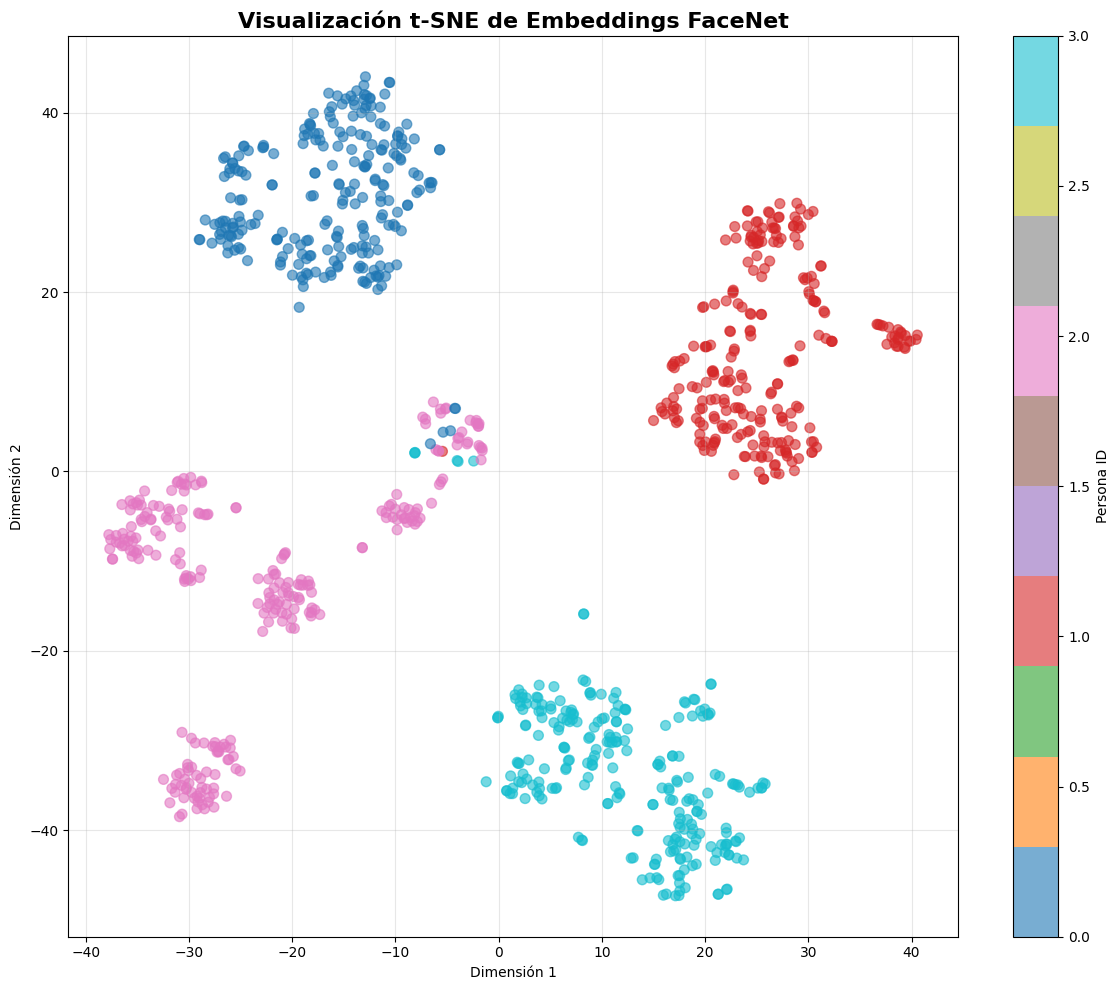

✓ Visualización t-SNE guardada en models\embeddings_tsne.png


In [20]:
# Visualizar embeddings con t-SNE (opcional, requiere sklearn)
try:
    from sklearn.manifold import TSNE
    
    print("Calculando t-SNE de embeddings (puede tomar un momento)...")
    
    # Usar una muestra si el dataset es muy grande
    max_samples = 1000
    if len(X_train) > max_samples:
        indices = np.random.choice(len(X_train), max_samples, replace=False)
        embeddings_sample = X_train[indices]
        labels_sample = np.argmax(y_train[indices], axis=1)
    else:
        embeddings_sample = X_train
        labels_sample = np.argmax(y_train, axis=1)
    
    # Calcular t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings_sample)
    
    # Visualizar
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1],
        c=labels_sample,
        cmap='tab10',
        alpha=0.6,
        s=50
    )
    plt.colorbar(scatter, label='Persona ID')
    plt.title('Visualización t-SNE de Embeddings FaceNet', fontsize=16, fontweight='bold')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(MODEL_SAVE_PATH / 'embeddings_tsne.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualización t-SNE guardada en {MODEL_SAVE_PATH / 'embeddings_tsne.png'}")
    
except ImportError:
    print("sklearn no disponible para t-SNE. Instalalo con: pip install scikit-learn")

# 20. Prueba con imágenes reales de TestImages

Cargar el modelo guardado y probar con imágenes reales del directorio TestImages

In [21]:
# Cargar modelo y label encoder guardados
from pathlib import Path
import pickle

# Rutas
TEST_IMAGES_PATH = Path('TestImages')
MODELS_PATH = Path('models')

# Cargar label encoder
with open(MODELS_PATH / 'label_encoder.pkl', 'rb') as f:
    label_encoder_loaded = pickle.load(f)

# Cargar mejor modelo entrenado
from tensorflow.keras.models import load_model
model_loaded = load_model(MODELS_PATH / 'best_classifier_model.h5')

print("="*70)
print("MODELOS CARGADOS CORRECTAMENTE")
print("="*70)
print(f"✓ Modelo: best_classifier_model.h5")
print(f"✓ Label encoder: label_encoder.pkl")
print(f"✓ Clases reconocidas: {list(label_encoder_loaded.classes_)}")
print("="*70 + "\n")

MODELOS CARGADOS CORRECTAMENTE
✓ Modelo: best_classifier_model.h5
✓ Label encoder: label_encoder.pkl
✓ Clases reconocidas: [np.str_('AlisonSalas'), np.str_('FreddyAlvarez'), np.str_('IsmaelSailema'), np.str_('WilliamChimborazo')]



In [22]:
# Función para detectar rostro, extraer embedding y predecir
def predict_from_test_image(image_path, facenet_model, classifier_model, label_encoder, threshold=0.75):
    """
    Detecta rostro en imagen de prueba, extrae embedding y predice identidad
    
    Args:
        image_path: Ruta a la imagen de prueba
        facenet_model: Modelo FaceNet para embeddings
        classifier_model: CNN clasificadora entrenada
        label_encoder: Codificador de labels
        threshold: Umbral de confianza mínimo (recomendado 0.75-0.85 para evitar falsos positivos)
    
    Returns:
        predicted_name, confidence, face_detected
    """
    import cv2
    import numpy as np
    
    # Cargar imagen
    img = cv2.imread(str(image_path))
    if img is None:
        return "Error: No se pudo cargar imagen", 0.0, False
    
    # Convertir a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detectar rostro con Haar Cascade
    cascade_frontal = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = cascade_frontal.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60, 60)
    )
    
    if len(faces) == 0:
        return "No se detectó rostro", 0.0, False
    
    # Tomar el rostro más grande
    (x, y, w, h) = max(faces, key=lambda face: face[2] * face[3])
    
    # Recortar rostro con padding
    padding = 20
    top = max(0, y - padding)
    left = max(0, x - padding)
    bottom = min(img_rgb.shape[0], y + h + padding)
    right = min(img_rgb.shape[1], x + w + padding)
    
    face_crop = img_rgb[top:bottom, left:right]
    
    # Redimensionar a 160x160
    face_resized = cv2.resize(face_crop, (160, 160))
    
    # Extraer embedding con FaceNet
    face_batch = np.expand_dims(face_resized, axis=0)
    embedding = facenet_model.embeddings(face_batch)
    
    # Predecir con clasificador
    prediction = classifier_model.predict(embedding, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Análisis adicional: verificar si hay otras clases con confianza similar
    # Si la diferencia entre la mejor y la segunda mejor es pequeña, es señal de incertidumbre
    sorted_probs = np.sort(prediction[0])[::-1]
    confidence_gap = sorted_probs[0] - sorted_probs[1] if len(sorted_probs) > 1 else sorted_probs[0]
    
    # Aplicar umbral más estricto
    # Considerar "Desconocido" si:
    # 1. La confianza es menor al threshold
    # 2. O si la diferencia entre top-1 y top-2 es muy pequeña (< 0.15)
    if confidence < threshold or confidence_gap < 0.15:
        predicted_name = "Desconocido"
    else:
        predicted_name = label_encoder.classes_[predicted_class]
    
    return predicted_name, confidence, True

print("✓ Función de predicción definida")
print("  - Threshold por defecto: 0.75 (75%)")
print("  - Análisis de confianza mejorado para detectar personas desconocidas")


✓ Función de predicción definida
  - Threshold por defecto: 0.75 (75%)
  - Análisis de confianza mejorado para detectar personas desconocidas


PROBANDO CON 5 IMÁGENES DE TestImages
Threshold configurado: 0.75 (75%) - Mayor precisión para detectar desconocidos

Procesando: freddy.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
  ✓ Predicción: FreddyAlvarez | Confianza: 84.14% | RECONOCIDO

Procesando: Isma.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
  ✓ Predicción: IsmaelSailema | Confianza: 95.33% | RECONOCIDO

Procesando: luis.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
  ⚠ Predicción: Desconocido | Confianza: 69.70% | DESCONOCIDO

Procesando: Rafa.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
  ⚠ Predicción: Desconocido | Confianza: 64.55% | DESCONOCIDO

Procesando: william.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
  ✓ Predicción: WilliamChimborazo | Confianza: 81.02% | RECONOCIDO



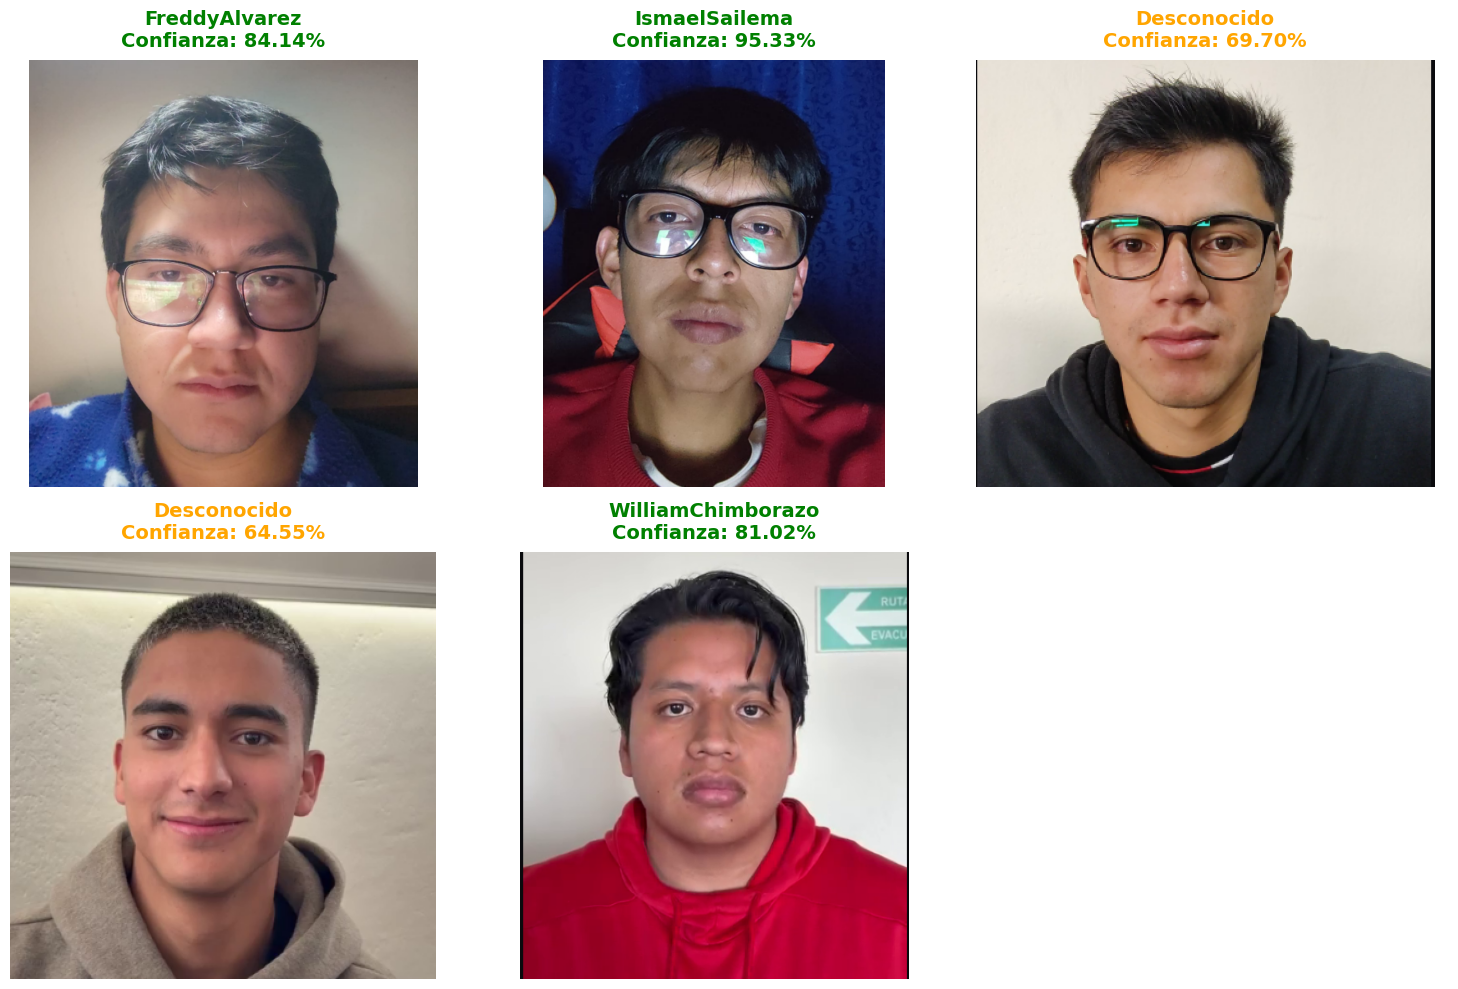


PRUEBAS COMPLETADAS
✓ Resultados guardados en models\test_images_results.png

💡 NOTA: Si ves muchos 'Desconocido', puedes ajustar el threshold:
   - threshold=0.70 → Más permisivo (puede dar falsos positivos)
   - threshold=0.75 → Balance recomendado (actual)
   - threshold=0.80 → Más estricto (menos falsos positivos)


In [23]:
# Probar con todas las imágenes de TestImages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Buscar todas las imágenes en TestImages
test_images = list(TEST_IMAGES_PATH.glob('*.png')) + list(TEST_IMAGES_PATH.glob('*.jpg'))

if not test_images:
    print("⚠ No se encontraron imágenes en TestImages/")
else:
    print("="*70)
    print(f"PROBANDO CON {len(test_images)} IMÁGENES DE TestImages")
    print(f"Threshold configurado: 0.75 (75%) - Mayor precisión para detectar desconocidos")
    print("="*70 + "\n")
    
    # Crear figura para mostrar resultados
    num_images = len(test_images)
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if num_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if num_images > 1 else [axes]
    
    # Procesar cada imagen
    for idx, img_path in enumerate(test_images):
        print(f"Procesando: {img_path.name}")
        
        # Predecir con threshold más estricto (0.75)
        name, confidence, detected = predict_from_test_image(
            img_path, 
            facenet_model, 
            model_loaded, 
            label_encoder_loaded,
            threshold=0.80  # Threshold aumentado para mayor precisión
        )
        
        # Cargar imagen para visualización
        img = mpimg.imread(str(img_path))
        
        # Mostrar resultado
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        if detected:
            color = 'green' if name != "Desconocido" else 'orange'
            title = f"{name}\nConfianza: {confidence:.2%}"
        else:
            color = 'red'
            title = name
        
        axes[idx].set_title(title, fontsize=14, fontweight='bold', color=color, pad=10)
        
        # Imprimir resultado en consola
        if detected:
            status = "✓" if name != "Desconocido" else "⚠"
            resultado = "RECONOCIDO" if name != "Desconocido" else "DESCONOCIDO"
            print(f"  {status} Predicción: {name} | Confianza: {confidence:.2%} | {resultado}")
        else:
            print(f"  ✗ {name}")
        print()
    
    # Ocultar ejes extra si hay menos imágenes que subplots
    for idx in range(len(test_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(MODELS_PATH / 'test_images_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("PRUEBAS COMPLETADAS")
    print("="*70)
    print(f"✓ Resultados guardados en {MODELS_PATH / 'test_images_results.png'}")
    print("\n💡 NOTA: Si ves muchos 'Desconocido', puedes ajustar el threshold:")
    print("   - threshold=0.70 → Más permisivo (puede dar falsos positivos)")
    print("   - threshold=0.75 → Balance recomendado (actual)")
    print("   - threshold=0.80 → Más estricto (menos falsos positivos)")
    print("="*70)
